In [2]:
from non_dim_glider import glider
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
# N_list = [50, 100, 200, 400]
N = 150
solve_second_optim = False
using_opt_guess = True
use_upsampled_prior = False
energy_optimal = False

x_opt, u_opt, opt_guess, sol = glider(
    N=N,
    use_upsampled_prior=use_upsampled_prior,
    y_f=-100,
    x_f=50,
    solve_2nd_optim=solve_second_optim,
    using_opt_guess=using_opt_guess,
    energy_optimal=energy_optimal,
)

-----------------
The number of control intervals is 150
-----------------
The time step is 0.006666666666666667
The dimension of the state is 7
The dimension of the control is 1
The number of parameters is 1
---


Using opt_guess

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    29522
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:     8850

Total number of variables....................

The final x is 50.00049826771332


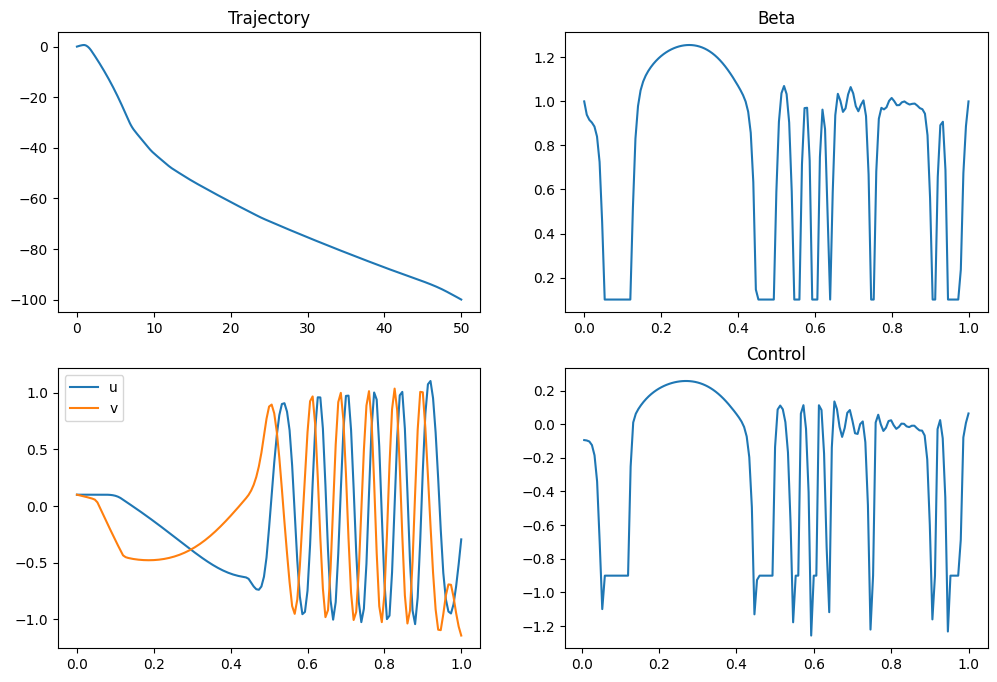

In [4]:
tgrid = np.linspace(0, 1, N + 1)
final_x = x_opt[3][-1]
print(f"The final x is {final_x}")

# plot results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax[0, 0].plot(x_opt[3], x_opt[4])
ax[0, 0].set_title("Trajectory")
ax[0, 1].plot(tgrid, x_opt[-1])
ax[0, 1].set_title("Beta")
ax[1, 0].plot(tgrid, x_opt[0])
ax[1, 0].plot(tgrid, x_opt[1])
ax[1, 0].legend(("u", "v"))
ax[1, 1].plot(tgrid, np.append(np.nan, u_opt[0]))
ax[1, 1].set_title("Control")
plt.show()

In [5]:
np.save("x_opt", x_opt)
np.save("u_opt", u_opt)

# Open a file and use dump()
# if solve_second_optim:
#     pass
# else:
#     with open("opt_guess_with_beta_dot.pkl", "wb") as file:
#         # A new file will be created
#         pickle.dump(opt_guess, file)

In [6]:
with open("opt_guess_non_dim.pkl", "wb") as file:
    # A new file will be created
    pickle.dump(opt_guess, file)

In [7]:
sol

{'f': DM(0.254932),
 'g': DM([-1.54355e-17, -1.30104e-17, -4.65868e-21, ..., 0.000498268, 0.000499857, 1.82642e-06]),
 'lam_g': DM([-0.366826, 0.0330425, 0.746729, ..., 0.00143325, 0.0164042, -0.00135953]),
 'lam_p': DM([]),
 'lam_x': DM([7.63837e-11, 0, 0, ..., -0.00157135, 0, -2.5059e-09]),
 'x': DM([153.017, 0.1, 0.1, ..., -100, 38.485, 1])}

In [8]:
(np.mod(38.485, 2 * np.pi) - np.pi / 4) / (np.pi / 4)

0.0006238791327371629

In [9]:
def construct_initial_guess_upsampled(
    p0: float, x_opt: np.ndarray, u_opt: np.ndarray, N: int, new_N: int
) -> list:
    """
    Construct an initial guess using a given solution.

    The initial guess has the form (p0, x0, u0, ....) where the
    ... is the sequence of states and controls that follows the
    initial state/control. The only trick is that the state
    gets copied 4 times after each control. This method creates
    a new "upsampled" guess based on a good old solution. By upsampled
    I simply mean it will serve as a guess for a problem with a larger
    N. I do the upsampling by simply repeating the state and control
    from the end of the current solution.

    Parameters
    ----------
    p0 : float
        Initial guess for the parameter.
    x_opt: np.ndarray
        Array containing state along the optimal solution.
    u_opt: np.ndarray
        Arracy containing the control along the optimal trajectory.
    N: int
        Original number of control intervals.
    new_N: int
        New number of control intervals.
    """
    w0 = [[p0]]
    print(new_N)
    for i in range(new_N + 1):
        if i > N - 1:
            k = -1
        else:
            k = i
        state = list(x_opt[:, k])
        if i == 0:
            w0.append(state)
            u = [u_opt[0, i]]
            w0.append(u)
        elif i == new_N:
            for j in range(4):
                w0.append(state)
        elif i > 0 and i < new_N:
            for j in range(4):
                w0.append(state)
            u = [u_opt[0, k]]
            w0.append(u)
    return w0


upsamp = construct_initial_guess_upsampled(
    p0=153.017, x_opt=x_opt, u_opt=u_opt, N=N, new_N=150
)
upsamp = np.concatenate(upsamp)

150


In [10]:
upsamp

array([ 1.53017000e+02,  1.00000000e-01,  1.00000000e-01, ...,
       -9.99999994e+01,  3.84850099e+01,  1.00000183e+00])

In [11]:
np.save("upsamp_w0", upsamp)

In [12]:
# # generate the videos
# create_video = solve_second_optim
# if create_video:
#     !python trajectory_viz.py
#     if energy_optimal:
#         !mkdir energy_opt
#         !mv u_opt.npy x_opt.npy logged_info.png sample_oct.mp4 w0.npy double_w0.npy energy_opt
#     else:
#         !mkdir time_opt
#         !mv u_opt.npy x_opt.npy logged_info.png sample_oct.mp4 w0.npy double_w0.npy time_opt

In [13]:
!python trajectory_viz.py -p "./"

Writing video
Plotting logged data


In [14]:
!open sample_oct.mp4

In [ ]:
x_opt[-1].mean()